In [1]:
import torch
from modelscope import AutoModel
from PIL import Image

## BGE-VL-v1.5-zs

In [ ]:
MODEL_NAME= "/home/public/dkx/model/BAAI/BGE-VL-v1.5-zs"

model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
model.eval()
model.cuda()

In [12]:
with torch.no_grad():
    model.set_processor(MODEL_NAME)

    # query_inputs = model.data_process(
    #     text="Make the background dark, as if the camera has taken the photo at night",
    #     images="./assets/cir_query.png",
    #     q_or_c="q",
    #     task_instruction="Retrieve the target image that best meets the combined criteria by using both the provided image and the image retrieval instructions: "
    # )

    candidate_inputs = model.data_process(
        text="",
        images=[""],
        q_or_c="c",
    )

    # query_embs = model(**query_inputs, output_hidden_states=True)[:, -1, :]
    candi_embs = model(**candidate_inputs, output_hidden_states=True)[:, -1, :]

    # query_embs = torch.nn.functional.normalize(query_embs, dim=-1)
    candi_embs = torch.nn.functional.normalize(candi_embs, dim=-1)

    # scores = torch.matmul(query_embs, candi_embs.T)
print(candi_embs.shape)

FileNotFoundError: [Errno 2] No such file or directory: ''

## Qwen3-Embedding

In [2]:
import torch.nn.functional as F
from torch import Tensor
from modelscope import AutoTokenizer
from transformers import Qwen3Model

In [3]:
def last_token_pool(last_hidden_states: Tensor,
                        attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery:{query}'

# Each query must come with a one-sentence instruction that describes the task
task = 'Given a piece of text, recommend the most suitable type of chart to visualize it.'

queries = [
    get_detailed_instruct(task, 'What is the capital of China?'),
    get_detailed_instruct(task, 'Explain gravity')
]
# No need to add instruction for retrieval documents
documents = [
        "The capital of China is Beijing.",
        "Gravity is a force that attracts two bodies towards each other. It gives weight to physical objects and is responsible for the movement of planets around the sun."
]

input_texts = queries + documents
tokenizer = AutoTokenizer.from_pretrained('/home/public/dkx/model/Qwen/Qwen3-Embedding-8B', padding_side='left')
model = Qwen3Model.from_pretrained('/home/public/dkx/model/Qwen/Qwen3-Embedding-8B')
# We recommend enabling flash_attention_2 for better acceleration and memory saving.
# model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-8B', attn_implementation="flash_attention_2", torch_dtype=torch.float16).cuda()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
# Tokenize the input texts
with torch.no_grad():
    batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=8192,
    return_tensors="pt",
)
    batch_dict.to(model.device)
    outputs = model(**batch_dict)
    embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    # normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    print(torch.sum(torch.norm(embeddings[0, :], p=2, dim=-1)))

tensor(1.0000)


In [ ]:
scores = (embeddings[:2] @ embeddings[2:].T)

## so400m-long-ctx309

In [2]:
from transformers import SiglipModel, SiglipProcessor

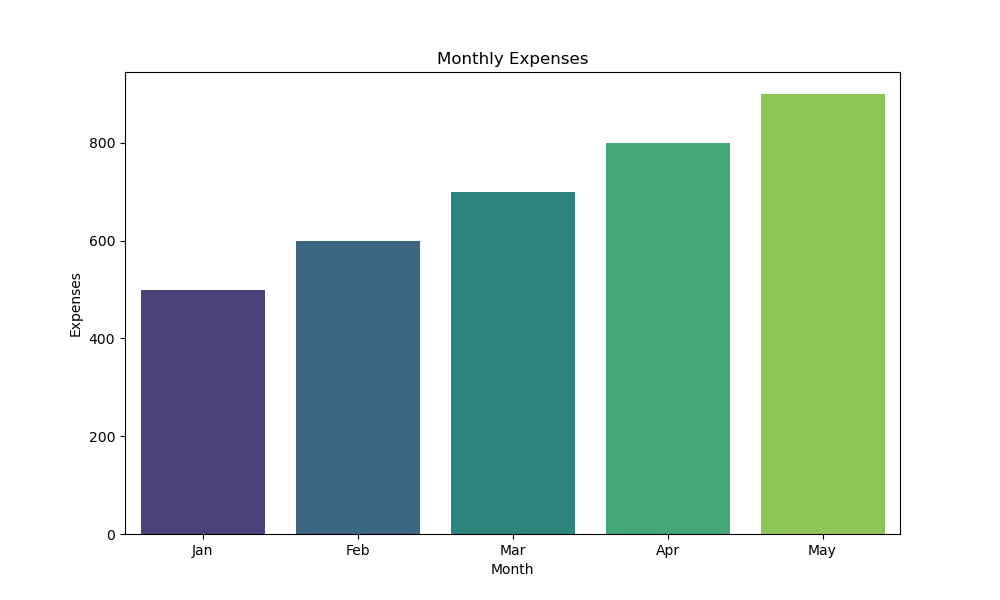

In [2]:
image = Image.open("/home/public/ChartGen-200K/converted/train/bar/png/12341_01.png")

display(image)

In [7]:
model = SiglipModel.from_pretrained("/home/public/dkx/model/fancyfeast/so400m-long-ctx309", torch_dtype=torch.float16, device_map="auto", attn_implementation="sdpa")
processor = SiglipProcessor.from_pretrained("/home/public/dkx/model/fancyfeast/so400m-long-ctx309")

images = [
    Image.open("/home/dkx/RAG4Ghart/Dataset-ZXQ/sample100/bar/png/21.png").convert('RGB'),
    Image.open("/home/dkx/RAG4Ghart/Dataset-ZXQ/sample100/line/png/3.png").convert('RGB'),
]

texts = ["a bar chart", "a line chart"]
inputs = processor(text=texts, images=images, padding="max_length", max_length=309, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)

print(outputs.text_embeds[0] @ outputs.image_embeds[0])
print(outputs.text_embeds[0] @ outputs.image_embeds[1])
print(outputs.text_embeds[1] @ outputs.image_embeds[0])
print(outputs.text_embeds[1] @ outputs.image_embeds[1])

tensor(0.1109, device='cuda:0', dtype=torch.float16)
tensor(0.0768, device='cuda:0', dtype=torch.float16)
tensor(0.0865, device='cuda:0', dtype=torch.float16)
tensor(0.1050, device='cuda:0', dtype=torch.float16)


In [14]:
torch.norm(outputs.text_embeds[0], p=2)
torch.norm(outputs.image_embeds[0], p=2)

tensor(1., device='cuda:0', dtype=torch.float16)

In [12]:
data = [{"text": 1}, {"text": 2}]
for datum in data:
    datum["text"] = 3
data

[{'text': 3}, {'text': 3}]

## colpali-v1.3-merged

In [2]:
from colpali_engine.models import ColPali, ColPaliProcessor

In [3]:
model_name = "/home/public/dkx/model/vidore/colpali-v1.3-merged"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # or "mps" if on Apple Silicon
).eval()
processor = ColPaliProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
# Your inputs
images = [
    Image.open("/home/dkx/RAG4Ghart/Dataset-ZXQ/sample100/bar/png/21.png").convert('RGB'),
    Image.open("/home/dkx/RAG4Ghart/Dataset-ZXQ/sample100/line/png/3.png").convert('RGB'),
]

queries = ["a bar chart", "a line chart"]

# Process the inputs
batch_images = processor.process_images(images).to(model.device)
batch_queries = processor.process_queries(queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images)
    query_embeddings = model(**batch_queries)

processor.score(query_embeddings, image_embeddings)

tensor([[13.0000, 11.3750],
        [12.9375, 12.9375]])

In [12]:
print(query_embeddings.shape)
print(image_embeddings.shape)

torch.Size([2, 16, 128])
torch.Size([2, 1031, 128])
